In [ ]:
import torch
from loguru import logger
from tqdm import tqdm
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

import mdtraj as md
import nglview as nv

from rocketshp import config
from rocketshp.plot import display_trajectory
from rocketshp.datasets.atlas import ATLASDataModule
from rocketshp.modeling.architectures import FlexibilityModelWithTemperature, DynCorrModelWithTemperature

2024-12-18 10:40:30.297 | INFO     | rocketshp.config:<module>:13 - PROJ_ROOT path is: /mnt/home/ssledzieski/Projects/rocketshp
/home/ssledzieski/miniforge3/envs/torch/lib/python3.11/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [5]:
config_file = "../configs/config.yml"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/foldseek_0.2_split/model-epoch=14-train_loss=0.01.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/foldseek_0.2_split_CA_loss/model-epoch=02-train_loss=2.68.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/foldseek_0.2_split_CA_loss/model-epoch=07-train_loss=2.66.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/foldseek_0.2_split_sqformer/model-epoch=15-train_loss=13.01.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/new_unstack_before_loss/model-epoch=02-train_loss=0.83.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/new_unstack_before_loss.2/model-epoch=17-train_loss=0.28.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/revert_loss/model-epoch=17-train_loss=0.29.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/retesting_old/model-epoch=02-train_loss=0.69.pt.ckpt"
checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/temperature_atlas/model-epoch=10-train_loss=0.36.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/dyncorr_test2/model-epoch=04-train_loss=0.31.pt.ckpt"

PARAMS = config.DEFAULT_PARAMETERS
PARAMS.update(OmegaConf.load(config_file))


In [6]:
adl = ATLASDataModule(config.PROCESSED_DATA_DIR / "atlas/atlas_processed.h5",
                      seq_features=True, struct_features=True,
                      batch_size=8, num_workers=PARAMS.num_data_workers,
                      train_pct=PARAMS.train_pct, val_pct=PARAMS.val_pct,
                      random_seed=PARAMS.random_seed,
                      )
adl.setup("train")
ads = adl.dataset
logger.info(f"{len(adl.dataset)}, {len(adl.train_data)}, {len(adl.val_data)}, {len(adl.test_data)}")

2024-12-18 10:40:40.592 | INFO     | __main__:<module>:9 - 4167, 3360, 396, 411


In [ ]:
model = FlexibilityModelWithTemperature.load_from_checkpoint(checkpoint_file, strict=True)
# model = FlexibilityModel.load_from_checkpoint(checkpoint_file, strict=False)
# model = DynCorrModelWithTemperature.load_from_checkpoint(checkpoint_file, strict=True)

/mnt/home/ssledzieski/Projects/rocketshp/rocketshp/modeling/architectures.py:210: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chk = torch.load(checkpoint_path)


2024-12-18 10:40:42.891 | INFO     | __main__:<module>:36 - Protein: 2y1q_A/R1
2024-12-18 10:40:42.891 | INFO     | __main__:<module>:37 - Spearman: SignificanceResult(statistic=0.7818996399839993, pvalue=3.5239926511545986e-32)
2024-12-18 10:40:42.891 | INFO     | __main__:<module>:38 - Pearson: PearsonRResult(statistic=0.9847965343710712, pvalue=0.0)
2024-12-18 10:40:42.891 | INFO     | __main__:<module>:39 - MSE: 0.0022612030152231455


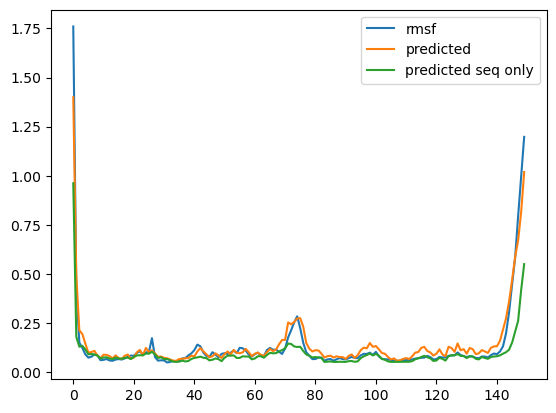

In [8]:
DATA_SUBSET = adl.test_data
# DATA_SUBSET = adl.val_data
# DATA_SUBSET = adl.train_data
SAMPLE_I = 192
# SAMPLE_I = 121

def normalize(x):
    return (x - x.mean()) / x.std()

feats, labels = DATA_SUBSET[SAMPLE_I]
key = adl.dataset.samples[DATA_SUBSET.indices[SAMPLE_I]]
with torch.no_grad():
        both_result = model({k: v.unsqueeze(0) for k, v in feats.items()})
        feats["struct_feats"] = torch.zeros_like(feats["struct_feats"])
        seqonly_result = model({k: v.unsqueeze(0) for k, v in feats.items()})

        yhat_both = both_result["rmsf"]
        sqfm_both = both_result["ca_dist"]
        
        yhat_seqonly = seqonly_result["rmsf"]
        sqfm_seqonly = seqonly_result["ca_dist"]

bf_both = yhat_both.detach().cpu().numpy().squeeze()
bf_seqonly = yhat_seqonly.detach().cpu().numpy().squeeze()

plt.plot(labels["rmsf"],label="rmsf")
plt.plot(bf_both,label="predicted")
plt.plot(bf_seqonly,label="predicted seq only")
plt.legend()


from scipy.stats import spearmanr, pearsonr
spearman = spearmanr(labels["rmsf"], bf_both)
pearson = pearsonr(labels["rmsf"], bf_both)
mse = ((labels["rmsf"] - bf_both)**2).mean()
logger.info(f"Protein: {key}")
logger.info(f"Spearman: {spearman}")
logger.info(f"Pearson: {pearson}")
logger.info(f"MSE: {mse}")

plt.show()

In [9]:
pdb_code, rep = key.split("/")
print(config.RAW_DATA_DIR  / f"atlas/{pdb_code[:2]}/{pdb_code}_prod_{rep}_fit.xtc",config.RAW_DATA_DIR  / f"atlas/{pdb_code[:2]}/{pdb_code}.pdb")
traj = md.load_xtc(config.RAW_DATA_DIR  / f"atlas/{pdb_code[:2]}/{pdb_code}_prod_{rep}_fit.xtc", top=config.RAW_DATA_DIR  / f"atlas/{pdb_code[:2]}/{pdb_code}.pdb")
view = display_trajectory(traj, bfactor=bf_both, coloring="bfactor", normalize=True, RMAX=0.3)
view

/mnt/home/ssledzieski/Projects/rocketshp/data/raw/atlas/2y/2y1q_A_prod_R1_fit.xtc /mnt/home/ssledzieski/Projects/rocketshp/data/raw/atlas/2y/2y1q_A.pdb


NGLWidget(max_frame=10000)

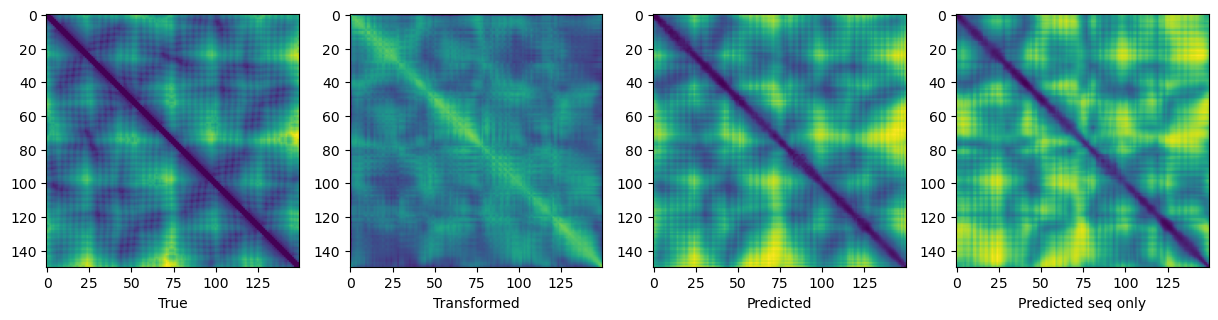

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(15, 10))
true_sqform = labels["ca_dist"].squeeze()
transform_sqform = model._cross_transform((feats["seq_feats"].unsqueeze(0), feats["struct_feats"].unsqueeze(0))).squeeze().detach().cpu().numpy()


ax[0].imshow(true_sqform.squeeze())
ax[0].set_xlabel("True")
ax[1].imshow(transform_sqform)
ax[1].set_xlabel("Transformed")
ax[2].imshow(sqfm_both.squeeze())
ax[2].set_xlabel("Predicted")
ax[3].imshow(sqfm_seqonly.squeeze())
ax[3].set_xlabel("Predicted seq only")
plt.show()

## Batch

In [8]:
fb, yb, lb = next(iter(adl.train_dataloader()))

In [10]:
predb = model(fb)

In [15]:
from rocketshp.datasets.data_utils import _unstack_variable_length_tensors

In [16]:
def _unstack_variable_size_squareforms(stacked, lengths):
        
    return [stacked[i, :sl, :sl] for i, sl in enumerate(lengths)]

In [17]:
tt = _unstack_variable_length_tensors(predb["rmsf"], lb)
sf = _unstack_variable_size_squareforms(predb["ca_dist"], lb)
tsf = _unstack_variable_size_squareforms(yb["ca_dist"], lb)

In [18]:
predb["ca_dist"].shape,yb["ca_dist"].shape,predb["rmsf"].shape,yb["rmsf"].shape

(torch.Size([8, 415, 415]),
 torch.Size([8, 415, 415]),
 torch.Size([8, 415, 1]),
 torch.Size([8, 415]))

In [ ]:
# from rocketshp.modeling.pt_lightning import compute_square_masked_mse_loss, compute_masked_mse_loss
# compute_masked_mse_loss(predb["rmsf"], yb["rmsf"].unsqueeze(-1), lb, rmse=True),compute_square_masked_mse_loss(predb["ca_dist"], yb["ca_dist"], lb, rmse=True)
import torch.nn as nn

outputs = predb["ca_dist"]
labels = yb["ca_dist"]
lengths = lb

rmse=False
pad_value=0.0

linmask = (torch.arange(outputs.shape[1], device=outputs.device)[None, :] < lengths[:, None])
squaremask = (linmask.unsqueeze(2) & linmask.unsqueeze(1))

# Use built-in MSELoss with reduction='none' to get per-element loss
mse_loss = nn.MSELoss(reduction='none')
init_loss = mse_loss(outputs, labels)

# Apply mask and compute mean over valid elements
masked_loss = init_loss * squaremask
mse = masked_loss.sum() / squaremask.sum()
print(mse)
print(masked_loss.sum(axis=(1,2)) / squaremask.sum(axis=(1,2)))
print()

# loss = torch.sqrt(mse) if rmse else mse
# print(loss)

tensor(0.1816, grad_fn=<DivBackward0>)
tensor([0.0730, 0.0730, 0.0730, 0.6660, 0.6660, 0.6660, 0.6465, 0.6465],
       grad_fn=<DivBackward0>)
tensor(0.4388, grad_fn=<MeanBackward0>)


In [39]:
ca_dist_pred_unstacked = _unstack_variable_size_squareforms(outputs, lengths)
ca_dist_true_unstacked = _unstack_variable_size_squareforms(labels, lengths)

reduce_loss = nn.MSELoss()
ca_dist_loss = []
for pred, true in zip(ca_dist_pred_unstacked, ca_dist_true_unstacked):
    ca_dist_loss.append(reduce_loss(pred, true))
# loss = torch.sqrt(ca_dist_loss) if rmse else ca_dist_loss
# print(loss)
print(torch.stack(ca_dist_loss))

tensor([0.0730, 0.0730, 0.0730, 0.6660, 0.6660, 0.6660, 0.6465, 0.6465],
       grad_fn=<StackBackward0>)


In [61]:
def compute_square_masked_mse_loss(outputs, labels, lengths, rmse=False, pad_value=0.0):
    linmask = (torch.arange(outputs.shape[1], device=outputs.device)[None, :] < lengths[:, None])
    squaremask = (linmask.unsqueeze(2) & linmask.unsqueeze(1))
    
    # Use built-in MSELoss with reduction='none' to get per-element loss
    mse_loss = nn.MSELoss(reduction='none')
    loss = mse_loss(outputs, labels)

    # Apply mask and compute mean over valid elements
    masked_loss = loss * squaremask
    # mse = masked_loss.sum() / squaremask.sum().clamp(min=1)
    mse = (masked_loss.sum(axis=(1,2)) / squaremask.sum(axis=(1,2))).mean()

    return torch.sqrt(mse) if rmse else mse

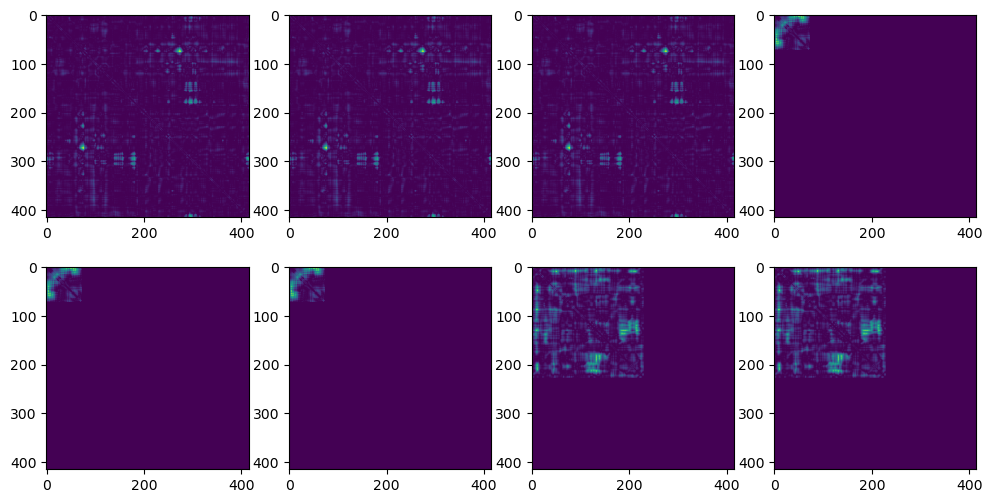

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

ax[0, 0].imshow(masked_loss[0].detach().cpu().numpy())
ax[0, 1].imshow(masked_loss[1].detach().cpu().numpy())
ax[0, 2].imshow(masked_loss[2].detach().cpu().numpy())
ax[0, 3].imshow(masked_loss[3].detach().cpu().numpy())
ax[1, 0].imshow(masked_loss[4].detach().cpu().numpy())
ax[1, 1].imshow(masked_loss[5].detach().cpu().numpy())
ax[1, 2].imshow(masked_loss[6].detach().cpu().numpy())
ax[1, 3].imshow(masked_loss[7].detach().cpu().numpy())
plt.show()

tensor(3.1176, grad_fn=<SqrtBackward0>)

In [19]:
x = model._transform((fb["seq_feats"], fb["struct_feats"]))

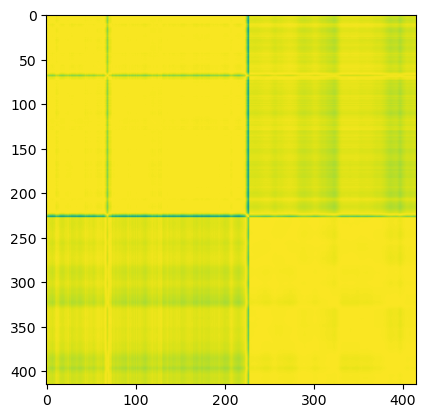

In [ ]:
plt.imshow((x @ x.transpose(1,2))[6].detach().cpu().numpy())

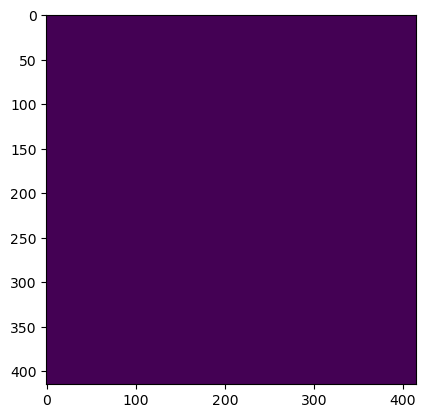

In [162]:
sqform_tensor = model.squareformer((x.unsqueeze(1) * x.unsqueeze(2)).transpose(1,3)).squeeze()
plt.imshow(sqform_tensor[0].detach().cpu().numpy())